<a href="https://colab.research.google.com/github/Yasmeenrafique/PRODIGY_GA_04/blob/main/Image_to_image_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow matplotlib numpy opencv-python


In [2]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/edges2shoes.tar.gz
!tar -xf edges2shoes.tar.gz


--2026-01-11 15:19:37--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/edges2shoes.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2165283376 (2.0G) [application/x-gzip]
Saving to: ‘edges2shoes.tar.gz’

edges2shoes.tar.gz  100%[===================>]   2.02G  3.88MB/s    in 13m 10s 

2026-01-11 15:32:47 (2.62 MB/s) - ‘edges2shoes.tar.gz’ saved [2165283376/2165283376]



In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

IMG_WIDTH = 256
IMG_HEIGHT = 256

def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    w = tf.shape(image)[1] // 2
    input_image = image[:, :w, :]
    target_image = image[:, w:, :]

    input_image = tf.image.resize(input_image, [256,256])
    target_image = tf.image.resize(target_image, [256,256])

    input_image = (input_image / 127.5) - 1
    target_image = (target_image / 127.5) - 1

    return input_image, target_image


In [13]:
train_dataset = tf.data.Dataset.list_files("edges2shoes/train/*.jpg", shuffle=True)
train_dataset = train_dataset.take(400)   # only 400 image pairs
train_dataset = train_dataset.map(load_image)
train_dataset = train_dataset.batch(1)




In [5]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    down = tf.keras.layers.Conv2D(64,4,strides=2,padding="same")(inputs)
    down = tf.keras.layers.LeakyReLU()(down)

    up = tf.keras.layers.Conv2DTranspose(3,4,strides=2,padding="same",activation="tanh")(down)

    return tf.keras.Model(inputs, up)


In [6]:
def Discriminator():
    inp = tf.keras.layers.Input(shape=[256,256,3])
    tar = tf.keras.layers.Input(shape=[256,256,3])

    x = tf.keras.layers.concatenate([inp, tar])
    x = tf.keras.layers.Conv2D(64,4,strides=2,padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(1,4,padding="same")(x)

    return tf.keras.Model([inp, tar], x)


In [7]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_obj(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return gan_loss + 100*l1_loss

def discriminator_loss(real_output, fake_output):
    real_loss = loss_obj(tf.ones_like(real_output), real_output)
    fake_loss = loss_obj(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss


In [8]:
generator = Generator()
discriminator = Discriminator()

gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real = discriminator([input_image, target], training=True)
        disc_fake = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_fake, gen_output, target)
        disc_loss = discriminator_loss(disc_real, disc_fake)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))


In [14]:
for epoch in range(2):
    for input_image, target in train_dataset:
        train_step(input_image, target)
    print(f"Epoch {epoch+1} completed")


Epoch 1 completed
Epoch 2 completed


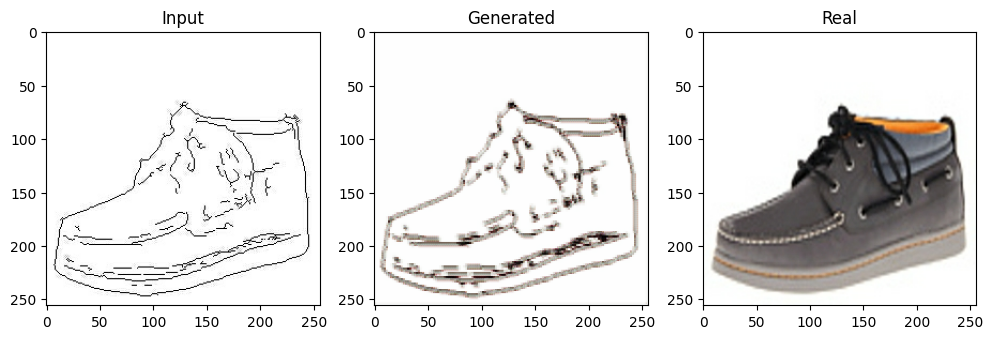

In [15]:
for input_image, target in train_dataset.take(1):
    prediction = generator(input_image, training=False)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow((input_image[0]+1)/2)
    plt.title("Input")
    plt.subplot(1,3,2)
    plt.imshow((prediction[0]+1)/2)
    plt.title("Generated")
    plt.subplot(1,3,3)
    plt.imshow((target[0]+1)/2)
    plt.title("Real")
    plt.show()
